<a href="https://colab.research.google.com/github/lehuyphuong/Vanishing_gradient/blob/feature%2Fadd_solution_project_vanishing_gradient/model_updated_by_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import library

In [ ]:
import random
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST
import numpy as np
import matplotlib.pyplot as plt

### Set up random seed

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_seed(SEED)

### Download dataset

In [ ]:
# download dataset
train_dataset = FashionMNIST('/content/drive/MyDrive/AIO_2024/Module_5/Week_4/data', train=True,
                             download=True,
                             transform=transforms.ToTensor())

test_dataset = FashionMNIST('/content/drive/MyDrive/AIO_2024/Module_5/Week_4/data', train=False,
                            download=True,
                            transform=transforms.ToTensor())


### Split dataset

In [ ]:
batch_size = 512


train_ratio = 0.9
train_size = int(len(train_dataset)*train_ratio)
val_size = len(train_dataset) - train_size

train_subnet, val_subnet = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subnet, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_subnet, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subnet)}")
print(f"Val size: {len(val_subnet)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Val size: 6000
Test size: 10000


### Define model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### MLP_1layer

In [ ]:
class MLP_1layer(nn.Module):
  def __init__(self, input_dims, output_dims):
    super(MLP_1layer, self).__init__()
    self.layer1 = nn.Linear(input_dims, output_dims)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.05)
        nn.init.constant_(module.bias, 0.0)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    return x

#### MLP_2layer

In [ ]:
class MLP_2layer(nn.Module):
  def __init__(self, input_dims, output_dims):
    super(MLP_2layer, self).__init__()
    self.layer1 = nn.Linear(input_dims, output_dims)
    self.layer2 = nn.Linear(output_dims, output_dims)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=1.0)
        nn.init.constant_(module.bias, 0.0)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    return x

### Train model

In [ ]:
first = MLP_2layer(input_dims=784, output_dims=128)
second = MLP_2layer(input_dims=128, output_dims=128)
third = MLP_2layer(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

#### Stage 1

In [ ]:
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# train model
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)

    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)

    val_acc /= count
    val_acc_lst.append(val_acc)
    print(f"Epoch {epoch + 1} / {epochs}, train_loss: {train_loss: .4f}, train_acc:{train_acc: .4f}, validation loss: {val_loss: .4f}, val_acc: {val_acc: .4f}")

Epoch 1 / 100, train_loss:  2.2174, train_acc: 0.2609, validation loss:  2.1184, val_acc:  0.3790
Epoch 2 / 100, train_loss:  2.0329, train_acc: 0.4701, validation loss:  1.9572, val_acc:  0.5188
Epoch 3 / 100, train_loss:  1.8822, train_acc: 0.5511, validation loss:  1.8202, val_acc:  0.5573
Epoch 4 / 100, train_loss:  1.7545, train_acc: 0.5831, validation loss:  1.7038, val_acc:  0.5892
Epoch 5 / 100, train_loss:  1.6455, train_acc: 0.6057, validation loss:  1.6032, val_acc:  0.6067
Epoch 6 / 100, train_loss:  1.5516, train_acc: 0.6213, validation loss:  1.5170, val_acc:  0.6163
Epoch 7 / 100, train_loss:  1.4711, train_acc: 0.6317, validation loss:  1.4419, val_acc:  0.6343
Epoch 8 / 100, train_loss:  1.4005, train_acc: 0.6436, validation loss:  1.3770, val_acc:  0.6427
Epoch 9 / 100, train_loss:  1.3387, train_acc: 0.6539, validation loss:  1.3198, val_acc:  0.6437
Epoch 10 / 100, train_loss:  1.2856, train_acc: 0.6599, validation loss:  1.2696, val_acc:  0.6528
Epoch 11 / 100, tra

#### Stage 2

In [ ]:
for param in first.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# train model
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)

    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)

    val_acc /= count
    val_acc_lst.append(val_acc)
    print(f"Epoch {epoch + 1} / {epochs}, train_loss: {train_loss: .4f}, train_acc:{train_acc: .4f}, validation loss: {val_loss: .4f}, val_acc: {val_acc: .4f}")

Epoch 1 / 100, train_loss:  2.2632, train_acc: 0.1926, validation loss:  2.2056, val_acc:  0.3237
Epoch 2 / 100, train_loss:  2.1516, train_acc: 0.4008, validation loss:  2.1016, val_acc:  0.4448
Epoch 3 / 100, train_loss:  2.0502, train_acc: 0.4800, validation loss:  2.0035, val_acc:  0.5093
Epoch 4 / 100, train_loss:  1.9535, train_acc: 0.5197, validation loss:  1.9094, val_acc:  0.5258
Epoch 5 / 100, train_loss:  1.8615, train_acc: 0.5427, validation loss:  1.8205, val_acc:  0.5542
Epoch 6 / 100, train_loss:  1.7746, train_acc: 0.5623, validation loss:  1.7360, val_acc:  0.5737
Epoch 7 / 100, train_loss:  1.6931, train_acc: 0.5786, validation loss:  1.6581, val_acc:  0.5807
Epoch 8 / 100, train_loss:  1.6174, train_acc: 0.5912, validation loss:  1.5860, val_acc:  0.5952
Epoch 9 / 100, train_loss:  1.5483, train_acc: 0.6018, validation loss:  1.5209, val_acc:  0.6102
Epoch 10 / 100, train_loss:  1.4856, train_acc: 0.6138, validation loss:  1.4615, val_acc:  0.6147
Epoch 11 / 100, tra

#### Stage 3

In [ ]:
for param in first.parameters():
  param.requires_grad = False
for param in second.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# train model
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)

    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)

    val_acc /= count
    val_acc_lst.append(val_acc)
    print(f"Epoch {epoch + 1} / {epochs}, train_loss: {train_loss: .4f}, train_acc:{train_acc: .4f}, validation loss: {val_loss: .4f}, val_acc: {val_acc: .4f}")

Epoch 1 / 100, train_loss:  2.2708, train_acc: 0.1785, validation loss:  2.2036, val_acc:  0.3238
Epoch 2 / 100, train_loss:  2.1449, train_acc: 0.4186, validation loss:  2.0860, val_acc:  0.4603
Epoch 3 / 100, train_loss:  2.0318, train_acc: 0.5131, validation loss:  1.9781, val_acc:  0.5320
Epoch 4 / 100, train_loss:  1.9266, train_acc: 0.5541, validation loss:  1.8769, val_acc:  0.5548
Epoch 5 / 100, train_loss:  1.8290, train_acc: 0.5754, validation loss:  1.7829, val_acc:  0.5763
Epoch 6 / 100, train_loss:  1.7385, train_acc: 0.5888, validation loss:  1.6979, val_acc:  0.5845
Epoch 7 / 100, train_loss:  1.6560, train_acc: 0.5971, validation loss:  1.6194, val_acc:  0.5945
Epoch 8 / 100, train_loss:  1.5811, train_acc: 0.6044, validation loss:  1.5494, val_acc:  0.6018
Epoch 9 / 100, train_loss:  1.5138, train_acc: 0.6104, validation loss:  1.4876, val_acc:  0.6060
Epoch 10 / 100, train_loss:  1.4546, train_acc: 0.6161, validation loss:  1.4321, val_acc:  0.6093
Epoch 11 / 100, tra

### Stage 4

In [ ]:
for param in first.parameters():
  param.requires_grad = False
for param in second.parameters():
  param.requires_grad = False
for param in third.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# train model
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)

    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)

    val_acc /= count
    val_acc_lst.append(val_acc)
    print(f"Epoch {epoch + 1} / {epochs}, train_loss: {train_loss: .4f}, train_acc:{train_acc: .4f}, validation loss: {val_loss: .4f}, val_acc: {val_acc: .4f}")

Epoch 1 / 100, train_loss:  2.3038, train_acc: 0.1417, validation loss:  2.2927, val_acc:  0.1777
Epoch 2 / 100, train_loss:  2.2846, train_acc: 0.2384, validation loss:  2.2783, val_acc:  0.2887
Epoch 3 / 100, train_loss:  2.2699, train_acc: 0.3414, validation loss:  2.2630, val_acc:  0.3552
Epoch 4 / 100, train_loss:  2.2543, train_acc: 0.4061, validation loss:  2.2475, val_acc:  0.4178
Epoch 5 / 100, train_loss:  2.2374, train_acc: 0.4585, validation loss:  2.2301, val_acc:  0.4292
Epoch 6 / 100, train_loss:  2.2190, train_acc: 0.4921, validation loss:  2.2108, val_acc:  0.5357
Epoch 7 / 100, train_loss:  2.1986, train_acc: 0.5241, validation loss:  2.1898, val_acc:  0.5418
Epoch 8 / 100, train_loss:  2.1758, train_acc: 0.5267, validation loss:  2.1663, val_acc:  0.5487
Epoch 9 / 100, train_loss:  2.1504, train_acc: 0.5425, validation loss:  2.1397, val_acc:  0.5533
Epoch 10 / 100, train_loss:  2.1223, train_acc: 0.5556, validation loss:  2.1107, val_acc:  0.5447
Epoch 11 / 100, tra

### Present results

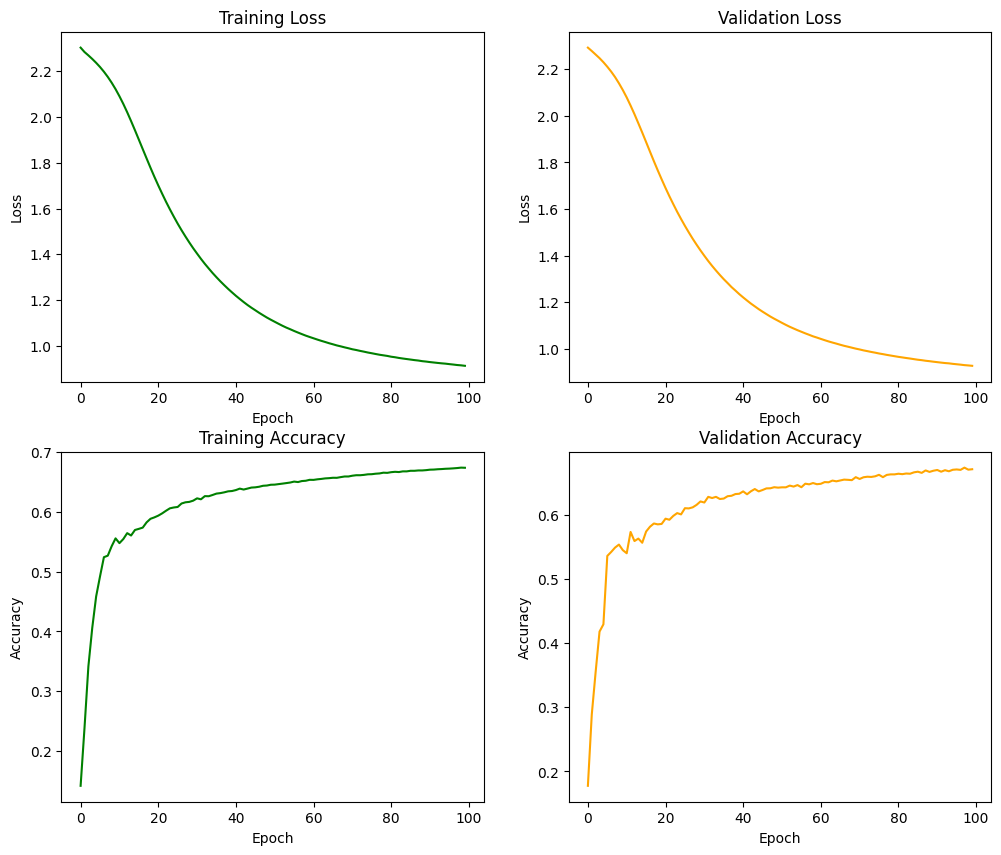

In [ ]:
# Present results
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

### Evaluation

In [ ]:
# Evaluation
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) ==
                test_target).sum().item()/len(test_target)

    print(f"Accuracy: {test_acc}")
    print("============================================================")

Accuracy: 0.668
